STEPS
1. DONE: Format and subset for columns and respondents of interest
2. Scale and normalize values
3. Run Principal Component Analysis (PCA)
4. Examine which components correlate with which variables
5. Generate elbow plot to identify ideal number of clusters
6. Run K-means clustering using elbow plot deemed number of PCs
7. Identify which variables are most associated with clustering 

In [6]:
# Load packages
import pandas as pd
import statistics
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import random
from matplotlib import cm

# Set random seed
random.seed(123)

In [7]:
# Load in data
data = pd.read_csv("./resources/merged.csv", index_col = 1)
data = data.iloc[: , 1:]

# REMOVE FOOD ONES
data = data.drop(["worry_food", "food_not_last", "balanced_meals"], axis = 1)

# Scale the data (z-score)
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data)
scaled_data = pd.DataFrame(scaled_data, columns = data.columns)
scaled_data.to_csv("./resources/merged_scaled_opt.csv")

In [8]:
# Initialize PCA model
pca_model = PCA(n_components=10, random_state=0)

# Get first two principal components
pca = pca_model.fit_transform(scaled_data)

In [9]:
# Transform PCA data to a DataFrame
pca_df = pd.DataFrame(data = pca, columns = ["PC1", "PC2", "PC3", "PC4", "PC5",
                                             "PC6", "PC7", "PC8", "PC9", "PC10"])
pca_df.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10
0,-0.415285,-0.334983,0.823548,-1.070036,0.140081,-0.482698,-0.062803,-0.239509,-0.196345,0.340143
1,-3.308668,-1.222760,-0.345593,0.981478,1.812234,-0.328236,0.071147,-0.325933,-0.382008,0.089059
2,1.083674,-2.552637,-2.850913,0.075266,-0.556378,0.632136,1.522555,-0.969224,-1.299764,0.638146
3,-0.669366,-1.245414,0.105586,0.310799,0.485427,-0.344996,-0.207974,-0.708951,-0.178872,0.416500
4,1.721420,1.638593,3.079505,1.015348,-0.874210,-2.217786,3.371663,0.003808,0.609059,0.640078


In [10]:
# Find loadings
loadings = pd.DataFrame(pca_model.components_.T,
                        columns = ["PC1", "PC2", "PC3", "PC4", "PC5",
                                   "PC6", "PC7", "PC8", "PC9", "PC10"],
                        index=data.columns)
loadings = loadings.abs()
loadings.sort_values(by = ["PC1"], ascending = False).head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10
food_security,0.384934,0.121129,0.010243,0.042555,0.068639,0.075981,0.016050,0.141619,0.034421,0.019764
monthly_income,0.380701,0.173695,0.076879,0.021290,0.057976,0.051119,0.052206,0.019647,0.082126,0.112770
family_savings,0.363213,0.111518,0.007558,0.117182,0.023109,0.092761,0.003518,0.081625,0.169049,0.194709
food_stamp,0.349671,0.077411,0.038381,0.086663,0.050039,0.048015,0.002001,0.273728,0.010621,0.066523
emergency_food,0.337615,0.081566,0.019629,0.078208,0.152477,0.036500,0.037930,0.323604,0.047506,0.120295


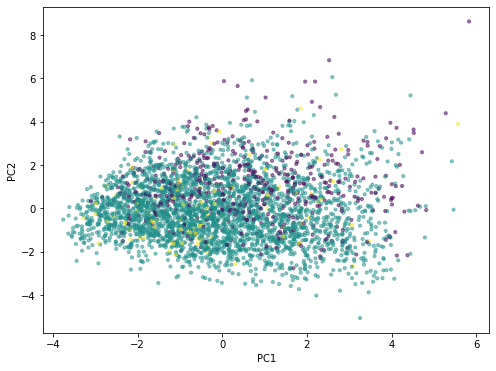

In [11]:
# Plot PCA
plt.scatter(pca_df['PC1'], pca_df['PC2'],
            c = scaled_data['diabetes'],
            s = 10,
            alpha = 0.5)
plt.xlabel('PC1')
plt.ylabel('PC2')
# plt.show()
figure = plt.gcf()
figure.set_size_inches(8, 6)
plt.savefig(f'results_opt/pca_diabetes.png', dpi = 300)

In [12]:
# Identify ideal number of clusters
inertia = []
k = list(range(1, 20))

# Calculate the inertia for the range of k values
for i in k:
    km = KMeans(n_clusters=i, random_state=0)
    km.fit(pca_df)
    inertia.append(km.inertia_)

# Create the Elbow Curve using hvPlot
elbow_data = {"k": k, "inertia": inertia}
df_elbow = pd.DataFrame(elbow_data)
df_elbow.head()

,k,inertia
0,1,53125.320927
1,2,45865.455371
2,3,42196.327868
3,4,39037.758144
4,5,36755.509393


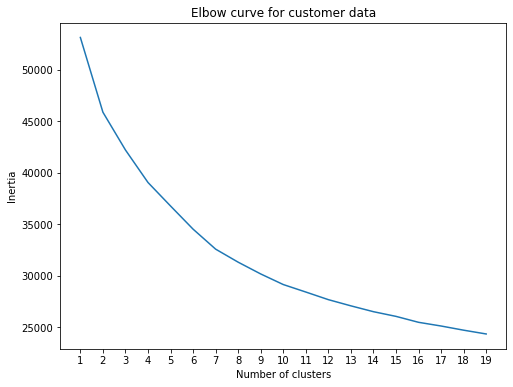

In [13]:
# Plot the elbow curve to find the best candidate(s) for k
plt.plot(df_elbow['k'], df_elbow['inertia'])
plt.xticks(range(1,20))
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow curve for customer data')
# plt.show()
figure = plt.gcf()
figure.set_size_inches(8, 6)
plt.savefig(f'results_opt/elbow_curve.png', dpi = 300)

In [14]:
# Initialize the K-Means model
model = KMeans(n_clusters=10, random_state=0)

# Train the model
model.fit(pca_df)

# Predict clusters
predictions = model.predict(pca_df)

# Create return DataFrame with predicted clusters
scaled_data["class"] = model.labels_

In [15]:
# Initialize t-SNE model
tsne = TSNE(learning_rate = 100, random_state=0)
tsne_features = tsne.fit_transform(pca_df)

# The first column of transformed features
pca_df['tnse_1'] = tsne_features[:,0]

# The second column of transformed features
pca_df['tnse_2'] = tsne_features[:,1]

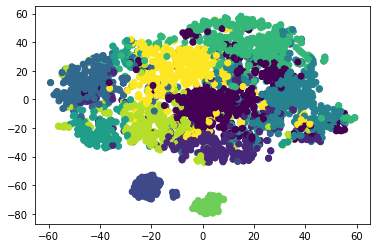

In [16]:
# Visualize the clusters
plt.scatter(pca_df['tnse_1'], pca_df['tnse_2'], c = scaled_data['class'])
plt.show()

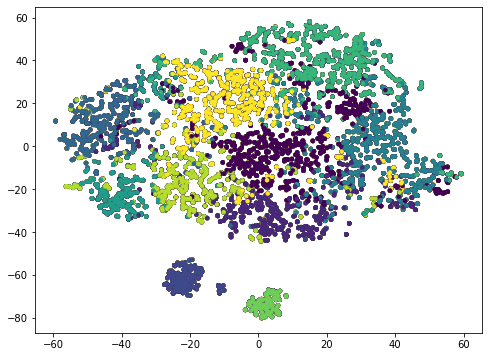

In [17]:
# Visualize the clusters
for var in scaled_data.columns:
    plt.scatter(pca_df['tnse_1'], pca_df['tnse_2'], c = scaled_data[var], s = 12)
    figure = plt.gcf()
    figure.set_size_inches(8, 6)
    plt.savefig(f'results_opt/tsne/tsne_{var}.png', dpi = 300)